## Deep Learning Workshop 2 - Batch Normalization for Both CNNs & FCDNs
2019/09/11

[ Reference ]
+ Rui Shu, "**TENSORFLOW GUIDE: BATCH NORMALIZATION**", 2016/12/26. http://ruishu.io/2016/12/27/batchnorm/
    + Github code: https://github.com/RuiShu/micro-projects/blob/master/tf-batchnorm/batchnorm_guide.ipynb
+ Antoine Labatie, "**It’s Necessary to Combine Batch Norm and Skip Connections**", Towards Data Science, 2019/09/01. https://towardsdatascience.com/its-necessary-to-combine-batch-norm-and-skip-connections-e92210ca04da
+ Federico Peccia, "**Batch normalization: theory and how to use it with Tensorflow**", , Towards Data Science, 2018/09/16. https://towardsdatascience.com/batch-normalization-theory-and-how-to-use-it-with-tensorflow-1892ca0173ad

-------------------------------
## [ CNNs ]: 
> 1. Please modify the TensorFlow code abovein **Case 1** for **CNNs**, and add "Convolution Layers" & "MaxPooling Layers", as following:
    + **Conv Layer 1**
    + **MaxPool Layer 1**
    + **Conv Layer 2**
    + **MaxPool Layer 2**
    + **Hidden Layer** 
    + **Hidden Layer** 
    + **Output Layer**
    
> 2. Using Batch Normalization by applying `tf.contrib.layers.batch_norm()` to `tf.contrib.layers.conv2d()`. 

> 3. And then, compare the results with those in **Case 1**.

[ REFERENCE ] :
+ dhwajraj, "How I can apply batch normalization?", 2016/12/07. https://github.com/dennybritz/cnn-text-classification-tf/issues/29
+ **`tf.contrib.layers.conv2d`**:https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d

> conv1 = `tf.contrib.layers.conv2d(...,
                                  normalizer_fn = tf.contrib.layers.batch_norm, 
                                  ...)`

> conv_out = `tf.nn.relu(conv1)`


+  **`tf.contrib.layers.batch_norm()`** :　https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

>+ It can be used as a **normalizer function** for `tf.contrib.layers.conv2d` and `tf.contrib.layers.fully_connected`. 
+ The normalization is over all but the last dimension if `data_format` is **NHWC** and all but the second dimension if `data_format` is **NCHW**. 
    + **NHWC** : (Samples, Height, Width, Channels)
    + **NCHW** : (Samples, Channels, Height, Width)
> + In case of a 2D tensor this corresponds to the batch dimension, while in case of a 4D tensor this corresponds to the batch and space dimensions.
------------------------

- [< Case Study > : Batch_Norm for Both CNNs & FCDNs](#BNforBoth)
- [< Exercise > : Batch_Norm for CIFAR-10 Dataset](#BNforCIFAR10)

In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
# for the old-version usage of TensorFlow, such as tensorflow.examples.tutorials.mnist
old_v = tf.logging.get_verbosity()          
tf.logging.set_verbosity(tf.logging.ERROR) 

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.12.0


### Input MNIST dataset 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print(" mnist.train.images.shape :\t ", mnist.train.images.shape)
print(" mnist.train.labels.shape :\t ", mnist.train.labels.shape)
print(" mnist.validation.images.shape : ", mnist.validation.images.shape)
print(" mnist.validation.labels.shape : ", mnist.validation.labels.shape)
print(" mnist.test.images.shape :\t ", mnist.test.images.shape)
print(" mnist.test.labels.shape :\t ", mnist.test.labels.shape)

mnist.test.labels[0]

 mnist.train.images.shape :	  (55000, 784)
 mnist.train.labels.shape :	  (55000, 10)
 mnist.validation.images.shape :  (5000, 784)
 mnist.validation.labels.shape :  (5000, 10)
 mnist.test.images.shape :	  (10000, 784)
 mnist.test.labels.shape :	  (10000, 10)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [4]:
images_data = mnist.train.images.reshape(55000, 28, 28, 1)
# images_data[0]

--------------------------------------
<a id='BNforBoth'></a>
## < Case Study > : Batch_Norm for Both CNNs & FCDNs


> + **[NOTE]: the `phase` term. **
    + useed as a **placeholder for a boolean** which we will insert into ``feed_dict`. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 

In [5]:
def train_test():
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    # --------------------------------------
    # Launch the computation graph...
    # --------------------------------------
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    history = []
    batch_size = 100
    iterep = 550
    epochs = 30
    
    ##  mnist.test.validation.shape : (5000, 784)
    X_val = mnist.validation.images.reshape(5, 1000, 28, 28, 1)
    ##  mnist.test.validation.shape : (5000, 10)
    Y_val = mnist.validation.labels.reshape(5, 1000, 10)   

    for i in range(iterep * epochs):
        x_train, y_train = mnist.train.next_batch(batch_size)
        
        x_train = x_train.reshape(batch_size, 28, 28, 1)
        
        sess.run(train_step,
                 feed_dict={'x:0': x_train, 
                            'y:0': y_train, 
                            'phase:0': 1})
        if (i + 1) %  iterep == 0:
            epoch = (i + 1)/iterep
            tr = sess.run([loss, accuracy], 
                          feed_dict={'x:0': x_train,
                                     'y:0': y_train,
                                     'phase:0': 1})

            t_loss = np.mean([sess.run(loss,
                                  feed_dict={'x:0': X_val[i], 
                                             'y:0': Y_val[i], 
                                             'phase:0': 0}) 
                                  for i in range(5)])
            t_accu = np.mean([sess.run(accuracy,
                                  feed_dict={'x:0': X_val[i], 
                                             'y:0': Y_val[i], 
                                             'phase:0': 0}) 
                                  for i in range(5)])
            t = [t_loss, t_accu]

            history += [[epoch] + tr + t]
            print(history[-1])
            
    print("\n Computing the test accuracy ... ", end = " ")
    
    ##  ------------------------------------------------------------------
    ##  Test datasets...
    ##
    ##  Split the test procedure into 10 blocks of 1,000 images each. 
    ##  Doing this is important mostly for much larger datasets.
    ##  ------------------------------------------------------------------
    ##  mnist.test.images.shape : (10000, 784)
    X_test = mnist.test.images.reshape(10, 1000, 28, 28, 1) 
    ##  mnist.test.labels.shape : (10000, 10)
    Y_test = mnist.test.labels.reshape(10, 1000, 10)   
    
    test_loss = np.mean([sess.run(loss,
                                  feed_dict={'x:0': X_test[i], 
                                             'y:0': Y_test[i], 
                                             'phase:0': 0}) 
                                  for i in range(10)])
    test_accu = np.mean([sess.run(accuracy,
                                  feed_dict={'x:0': X_test[i], 
                                             'y:0': Y_test[i], 
                                             'phase:0': 0}) 
                                  for i in range(10)])
    print(" Done !!! ")
    
    return history, test_accu, test_loss

## < Case 1 > : No batch normalization for Both CNNs & FCDNs

In [6]:
def dense(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, 
                                             activation_fn=None,
                                             scope=scope)

def dense_relu(x, size, scope):
    with tf.variable_scope(scope):
        h1 = dense(x, size, 'dense')
        return tf.nn.relu(h1, 'relu')

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

In [8]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 28, 28, 1), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# Conv layers with MaxPooling_2x2 layers
conv1 = conv_layer(x, shape=[3, 3, 1, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[3, 3, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 7 * 7 * 64])

# FCDNetwork with 2 hidden layers...
h1 = dense_relu(conv2_flat, 100, 'layer1')
h2 = dense_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [9]:
history, test_accu, test_loss = train_test()

[1.0, 0.34713078, 0.91, 0.3140219, 0.9044]
[2.0, 0.2725409, 0.92, 0.2226055, 0.93640006]
[3.0, 0.18453674, 0.95, 0.17173943, 0.9492]
[4.0, 0.09079796, 0.98, 0.14004815, 0.95980006]
[5.0, 0.15190345, 0.97, 0.120149255, 0.96500003]
[6.0, 0.046016593, 1.0, 0.09323557, 0.9732]
[7.0, 0.09513757, 0.99, 0.10268358, 0.9698]
[8.0, 0.042703696, 1.0, 0.08064942, 0.97580004]
[9.0, 0.12614034, 0.98, 0.07158618, 0.9782001]
[10.0, 0.025924297, 0.99, 0.075008795, 0.9764]
[11.0, 0.021404017, 1.0, 0.07739143, 0.9771999]
[12.0, 0.06941884, 0.96, 0.06822805, 0.9802]
[13.0, 0.034581054, 1.0, 0.060264986, 0.98340005]
[14.0, 0.031103438, 0.99, 0.05829494, 0.9834]
[15.0, 0.015991235, 1.0, 0.05558773, 0.98379993]
[16.0, 0.04551036, 0.99, 0.05375264, 0.98359996]
[17.0, 0.006980322, 1.0, 0.04996904, 0.98600006]
[18.0, 0.0057363473, 1.0, 0.048630644, 0.9854]
[19.0, 0.015285438, 1.0, 0.046932083, 0.9864]
[20.0, 0.078176275, 0.99, 0.04724298, 0.98599994]
[21.0, 0.0143761635, 1.0, 0.04885137, 0.98620003]
[22.0, 0.01

In [10]:
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 [ Test  Accuracy ] : 0.9874000549316406
 [ Test Loss Score ] : 0.03655169531702995


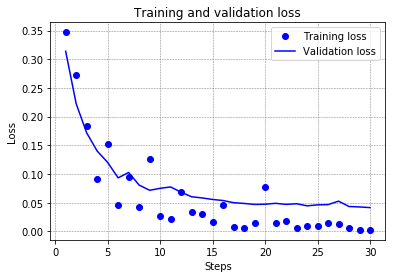

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(steps, [history[i][3] for i in range(len(history))], 
         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

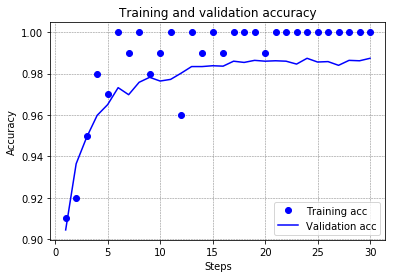

In [12]:
plt.clf()   # clear figure

plt.plot(steps, [history[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
plt.plot(steps, [history[i][4] for i in range(len(history))], 
         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## < Case 2 > : Standard batch normalization for Both CNNS & FCDNs
+ Batch normalization would be to simply use the `tf.contrib.layers.batch_norm layer`.
+ One thing that might stand out is the `phase` term. 
    + We are going to use as a **placeholder for a boolean** which we will insert into feed_dict. 
    + It will serve as a binary indicator for whether we are in **training phase=True** or **testing phase=False** mode. 
    
    
+ Recall that batch normalization has distinct behaviors during training verus test time:
> + Training
    1. Normalize layer activations according to mini-batch statistics.
    2. During the training step, update population statistics approximation via moving average of mini-batch statistics.
 + Testing
    1. Normalize layer activations according to estimated population statistics.
    2. Do not update population statistics according to mini-batch statistcs from test data.

In [13]:
def dense_batch_relu(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, 100, activation_fn=None, scope='dense')
        
        # Batch normalization would be to simply use the tf.contrib.layers.batch_norm layer.
        h2 = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training = phase,
                                          scope='bn')
        return tf.nn.relu(h2, 'relu')

In [14]:
def conv2d_bn(x, W, shape):
    # return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    return tf.contrib.layers.convolution2d(x, shape[3],
                [shape[0],shape[1]], padding='SAME', 
                normalizer_fn=tf.contrib.layers.batch_norm)

def conv_layer_bn(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d_bn(input, W, shape) + b)

In [15]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 28, 28, 1), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# Conv layers with MaxPooling_2x2 layers
conv1 = conv_layer_bn(x, shape=[3, 3, 1, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer_bn(conv1_pool, shape=[3, 3, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 7 * 7 * 64])

# FCDNetwork with 2 hidden layers...
h1 = dense_batch_relu(conv2_flat, 100, 'layer1')
h2 = dense_batch_relu(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [16]:
history_bn, test_accu_bn, test_loss_bn = train_test()

[1.0, 0.22819969, 0.94, 0.13482675, 0.97300005]
[2.0, 0.08690508, 0.97, 0.08695179, 0.97959995]
[3.0, 0.06347962, 0.99, 0.06824646, 0.98460007]
[4.0, 0.05149172, 1.0, 0.05769225, 0.98599994]
[5.0, 0.03236327, 1.0, 0.05209251, 0.987]
[6.0, 0.040290736, 1.0, 0.048348673, 0.9879999]
[7.0, 0.069080345, 0.98, 0.04474481, 0.98859996]
[8.0, 0.0363179, 0.99, 0.042220667, 0.98859996]
[9.0, 0.011895503, 1.0, 0.0404024, 0.98859996]
[10.0, 0.010452276, 1.0, 0.03892777, 0.9892]
[11.0, 0.026083268, 0.99, 0.037725653, 0.9892]
[12.0, 0.013770802, 1.0, 0.036054373, 0.9906]
[13.0, 0.01164564, 1.0, 0.035631113, 0.9898]
[14.0, 0.019283708, 1.0, 0.034873746, 0.99179995]
[15.0, 0.007813569, 1.0, 0.034028195, 0.99160004]
[16.0, 0.029040044, 0.99, 0.034023628, 0.99179995]
[17.0, 0.01403545, 1.0, 0.03350904, 0.99059993]
[18.0, 0.005218025, 1.0, 0.03221042, 0.9915999]
[19.0, 0.010956578, 1.0, 0.031602412, 0.991]
[20.0, 0.008619553, 1.0, 0.030878847, 0.99179995]
[21.0, 0.008404718, 1.0, 0.03098824, 0.9926001]
[2

In [17]:
print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.9902999997138977
 [ Test Loss Score ] : 0.029896069318056107

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9874000549316406
 [ Test Loss Score ] : 0.03655169531702995


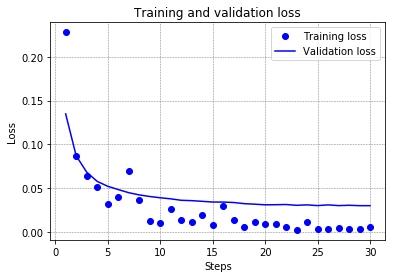

In [18]:
plt.clf()   # clear figure

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history_bn[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(steps, [history_bn[i][3] for i in range(len(history))], 
         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

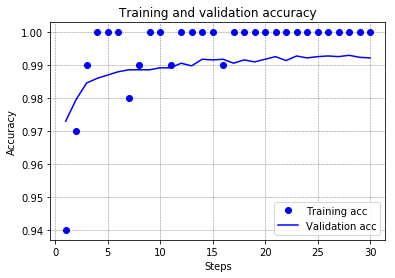

In [19]:
plt.clf()   # clear figure

plt.plot(steps, [history_bn[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
plt.plot(steps, [history_bn[i][4] for i in range(len(history))], 
         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## < Case 3 > : Post-activation batch normalization

In [20]:
def dense_relu_batch(x, phase, scope):
    with tf.variable_scope(scope):
        h1 = dense_relu(x, 100, scope='dense_relu')
        
        ##  Post-activation batch normalization...
        bn = tf.contrib.layers.batch_norm(h1, 
                                          center=True, scale=True, 
                                          is_training=phase,
                                          scope='bn')
        return bn

In [21]:
def conv_layer_relu_bn(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    relu_bn = tf.nn.relu(conv2d(input, W) + b)
    return tf.contrib.layers.convolution2d(relu_bn, shape[3],
                                        [shape[0],shape[1]], padding='SAME', 
                                        normalizer_fn=tf.contrib.layers.batch_norm)

In [22]:
# Reset the default graph...
tf.reset_default_graph()

# -------------------------------
# Build a computation graph...
# -------------------------------
x = tf.placeholder('float32', (None, 28, 28, 1), name='x')
y = tf.placeholder('float32', (None, 10), name='y')
phase = tf.placeholder(tf.bool, name='phase')

# Conv layers with MaxPooling_2x2 layers
conv1 = conv_layer_relu_bn(x, shape=[3, 3, 1, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer_relu_bn(conv1_pool, shape=[3, 3, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 7 * 7 * 64])

# FCDNetwork with 2 hidden layers...
h1 = dense_relu_batch(conv2_flat, 100, 'layer1')
h2 = dense_relu_batch(h1, 100, 'layer2')
logits = dense(h2, 10, scope='logits')

with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(y, 1), tf.argmax(logits, 1)), 
            'float32'))

with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [23]:
history_post_bn, test_accu_post_bn, test_loss_post_bn = train_test()

[1.0, 0.045322508, 1.0, 0.08017796, 0.9786]
[2.0, 0.032303844, 1.0, 0.056613702, 0.984]
[3.0, 0.034607735, 1.0, 0.04769642, 0.98599994]
[4.0, 0.01276288, 1.0, 0.045484014, 0.9878]
[5.0, 0.016088096, 1.0, 0.03954638, 0.98759997]
[6.0, 0.01239854, 1.0, 0.03746583, 0.9882]
[7.0, 0.006392347, 1.0, 0.03467653, 0.9892]
[8.0, 0.0110421525, 0.99, 0.036715463, 0.98719996]
[9.0, 0.007426095, 1.0, 0.034923926, 0.9896]
[10.0, 0.0053263623, 1.0, 0.03406713, 0.9894]
[11.0, 0.0038638455, 1.0, 0.033111595, 0.9894]
[12.0, 0.007110402, 1.0, 0.032611452, 0.98999995]
[13.0, 0.00859357, 1.0, 0.03281461, 0.9901999]
[14.0, 0.001952576, 1.0, 0.031936664, 0.9904]
[15.0, 0.0052928654, 1.0, 0.031189319, 0.991]
[16.0, 0.0050876033, 1.0, 0.032944076, 0.9896]
[17.0, 0.0028861982, 1.0, 0.03214668, 0.99039996]
[18.0, 0.0047184485, 1.0, 0.031180367, 0.9912]
[19.0, 0.003622198, 1.0, 0.030650303, 0.99160004]
[20.0, 0.001698384, 1.0, 0.031292476, 0.991]
[21.0, 0.00075279555, 1.0, 0.029972602, 0.991]
[22.0, 0.0025783242, 

In [24]:
print(" <<< Post-activation Batch Normalization >>> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_post_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_post_bn))

print(" << With Batch Normalization >> :")
print(" [ Test  Accuracy ] : {}".format(test_accu_bn) +
      "\n [ Test Loss Score ] : {}".format(test_loss_bn))

print("\n < Without Batch Normalization > :")
print(" [ Test  Accuracy ] : {}".format(test_accu) +
      "\n [ Test Loss Score ] : {}".format(test_loss))

 <<< Post-activation Batch Normalization >>> :
 [ Test  Accuracy ] : 0.9919999837875366
 [ Test Loss Score ] : 0.0247451514005661
 << With Batch Normalization >> :
 [ Test  Accuracy ] : 0.9902999997138977
 [ Test Loss Score ] : 0.029896069318056107

 < Without Batch Normalization > :
 [ Test  Accuracy ] : 0.9874000549316406
 [ Test Loss Score ] : 0.03655169531702995


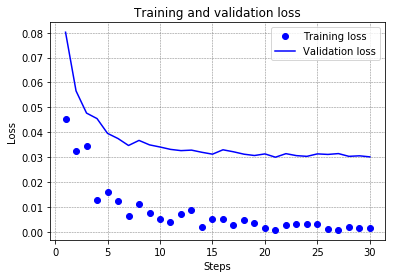

In [25]:
plt.clf()   # clear figure

steps = np.arange(1, len(history) + 1)

# "bo" is for "blue dot"
plt.plot(steps, [history_post_bn[i][1] for i in range(len(history))], 
         'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(steps, [history_post_bn[i][3] for i in range(len(history))], 
         'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

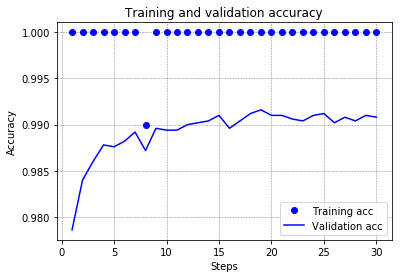

In [26]:
plt.clf()   # clear figure

plt.plot(steps, [history_post_bn[i][2] for i in range(len(history))], 
         'bo', label='Training acc')
plt.plot(steps, [history_post_bn[i][4] for i in range(len(history))], 
         'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
step_5 = np.arange(0, len(history) + 1, step=5)
plt.xticks(step_5)
plt.grid(color='grey', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

## Evaluation

In [27]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [28]:
history = np.array(history)
history_bn = np.array(history_bn)
history_post_bn = np.array(history_post_bn)

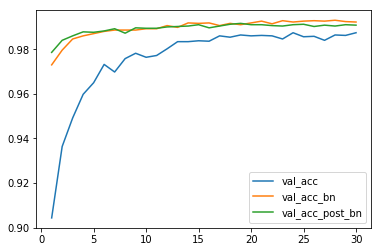

In [29]:
plt.plot(history[:, 0], history[:, -1], label='val_acc')
plt.plot(history_bn[:, 0], history_bn[:, -1], label='val_acc_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -1], label='val_acc_post_bn')
plt.legend()
plt.show()

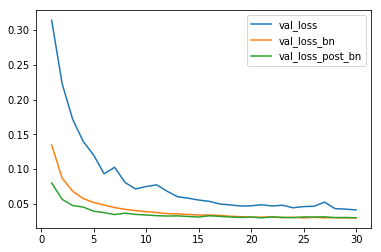

In [30]:
plt.clf()   # clear figure

plt.plot(history[:, 0], history[:, -2], label='val_loss')
plt.plot(history_bn[:, 0], history_bn[:, -2], label='val_loss_bn')
plt.plot(history_post_bn[:, 0], history_post_bn[:, -2], label='val_loss_post_bn')
plt.legend()
plt.show()

+ ### As you can see, batch normalization really does help with training (not always, but it certainly did in this example).

--------------------------------------
<a id='BNforCIFAR10'></a>
## < Exercise > : Batch_Norm for CIFAR-10 Datasets 

## [ Problem ]: 
> 1. Please modify the Case-Study TensorFlow code above for building a multiple-output classifier with the **CIFAR-10** dataset, which includes "Convolution Layers" & "MaxPooling Layers", as following:
    + **Conv Layer 1**
    + **MaxPool Layer 1**
    + **Conv Layer 2**
    + **MaxPool Layer 2**
    + **Hidden Layer** 
    + **Output Layer**
    
> 2. Using Batch Normalization by applying `tf.contrib.layers.batch_norm()` to `tf.contrib.layers.conv2d()`. 

> 3. And then, compare the results with those in the reference below:
    + Tom Hope, Yehezkel S. Resheff, and Itay Lieder, "**`Learning TensorFlow : A Guide to Building Deep Learning Systems`**", Chapter 4, O'Reilly, 2017.
      [ Code ] : https://github.com/giser-yugang/Learning_TensorFlow.

[ REFERENCE ] :
+ dhwajraj, "How I can apply batch normalization?", 2016/12/07. https://github.com/dennybritz/cnn-text-classification-tf/issues/29
+ `tf.contrib.layers.conv2d`:https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d

> conv1 = `tf.contrib.layers.conv2d(...,
                                  normalizer_fn = tf.contrib.layers.batch_norm, 
                                  ...)`

> conv_out = `tf.nn.relu(conv1)`